#### Housekeeping

In [1]:
%reset -f

import pandas as pd
import numpy as np
# import folium   
import os
# import branca.colormap as cm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
plt.rcParams.update({'font.size': 16})
from matplotlib.transforms import ScaledTranslation
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.ticker import AutoLocator
import seaborn as sns

import nrarfcn as nr
# https://gitlab.com/alexander_marder/earfcn
# https://pypi.org/project/earfcn/0.0.3/
from earfcn.convert import earfcn2freq

##### Bokeh plot function

In [2]:
import geopandas as gpd
from bokeh.plotting import figure, output_notebook, show, output_file
output_notebook()
from bokeh.models import ColumnDataSource, LinearColorMapper, ColorBar, HoverTool, WheelZoomTool, WMTSTileSource
from bokeh.palettes import Viridis256

Loading BokehJS ...

In [3]:
def plot_geo_scatter_map(df, value_col, title="Geo Map", colorbar_title="Value", unit=""):
    # Create GeoDataFrame and project to Web Mercator
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326").to_crs("EPSG:3857")
    gdf['x'], gdf['y'] = gdf.geometry.x, gdf.geometry.y

    # Setup Bokeh figure
    p = figure(
        title=title, width=800, height=500,
        x_axis_type="mercator", y_axis_type="mercator",
        tools="pan,reset,save",
        x_range=(gdf['x'].min()-300, gdf['x'].max()+300),
        y_range=(gdf['y'].min()-300, gdf['y'].max()+300)
    )
    p.add_tools(WheelZoomTool(zoom_on_axis=False))
    p.add_tile(WMTSTileSource(
        url='https://cartodb-basemaps-4.global.ssl.fastly.net/light_all/{Z}/{X}/{Y}.png',
        attribution="© CartoDB contributors")
    )

    # Color mapping and data source
    color_mapper = LinearColorMapper(palette=Viridis256, low=gdf[value_col].min(), high=gdf[value_col].max())
    source = ColumnDataSource(gdf[['x', 'y', value_col, 'Latitude', 'Longitude']])

    # Scatter points
    p.scatter(
        x='x', y='y', size=5, source=source,
        fill_color={'field': value_col, 'transform': color_mapper},
        line_color=None, fill_alpha=0.7
    )

    # Color bar and hover
    p.add_layout(ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title=colorbar_title), 'right')
    p.add_tools(HoverTool(tooltips=[
        ("Lat/Lon", "@{Latitude}, @{Longitude}"),
        (value_col, f"@{{{value_col}}} {unit}")
    ]))

    p.toolbar.active_drag = None
    p.toolbar.active_inspect = None

    show(p)

In [4]:
def plot_geo_binned_map(df, value_col, title="Geo Map", colorbar_title="Value", unit="", step_num=1e4):

    step_deg = step_num / 111.32e3  # convert meters to degrees
    to_bin = lambda x: np.floor(x / step_deg) * step_deg
    df = df.copy()
    df['lat_bin'] = to_bin(df['Latitude'])
    df['lon_bin'] = to_bin(df['Longitude'])
    binned = df.groupby(['lat_bin', 'lon_bin'])[value_col].max().reset_index()
    # binned = df.groupby(['lat_bin', 'lon_bin'])[value_col].mean().reset_index()
    def latlon_to_webm(lat, lon):
        k = 6378137
        x = k * np.radians(lon)
        y = k * np.log(np.tan(np.pi / 4 + np.radians(lat) / 2))
        return x, y
    binned['lat_max'] = binned['lat_bin'] + step_deg
    binned['lon_max'] = binned['lon_bin'] + step_deg
    x0, y0 = latlon_to_webm(binned['lat_bin'].values, binned['lon_bin'].values)
    x1, y1 = latlon_to_webm(binned['lat_max'].values, binned['lon_max'].values)
    binned['x0'], binned['x1'] = x0, x1
    binned['y0'], binned['y1'] = y0, y1

    # Setup Bokeh figure
    p = figure(
        title=title, width=800, height=500,
        x_axis_type="mercator", y_axis_type="mercator",
        tools="pan,reset,save",
        x_range=(min(x0)-100, max(x1)+100),
        y_range=(min(y0)-100, max(y1)+100)
    )
    p.add_tools(WheelZoomTool(zoom_on_axis=False))
    p.add_tile(WMTSTileSource(
        url='https://cartodb-basemaps-4.global.ssl.fastly.net/light_all/{Z}/{X}/{Y}.png',
        attribution="© CartoDB contributors")
    )

    # Color mapping and data source
    # color_mapper = LinearColorMapper(palette=Viridis256, low=binned[value_col].min(), high=binned[value_col].max())
    color_mapper = LinearColorMapper(palette=Viridis256, low=-135, high=-65)
    source = ColumnDataSource(binned)

    # Draw rectangles for each bin
    p.quad(
        top='y1', bottom='y0', left='x0', right='x1',
        source=source,
        fill_color={'field': value_col, 'transform': color_mapper},
        line_color=None, fill_alpha=0.7
    )

    # Color bar and hover
    p.add_layout(ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title=colorbar_title), 'right')
    p.add_tools(HoverTool(tooltips=[
        ("Lat Bin", "@lat_bin"),
        ("Lon Bin", "@lon_bin"),
        (value_col, f"@{{{value_col}}} {unit}")
    ]))

    p.toolbar.active_drag = None
    p.toolbar.active_inspect = None

    show(p)

In [5]:
def save_geo_binned_map(df, value_col, title="Geo Map", colorbar_title="Value", unit="", step_num=1e4, bounds=None):

    step_deg = step_num / 111.32e3  # convert meters to degrees
    to_bin = lambda x: np.floor(x / step_deg) * step_deg
    df = df.copy()
    df['lat_bin'] = to_bin(df['Latitude'])
    df['lon_bin'] = to_bin(df['Longitude'])
    binned = df.groupby(['lat_bin', 'lon_bin'])[value_col].max().reset_index()
    # binned = df.groupby(['lat_bin', 'lon_bin'])[value_col].mean().reset_index()
    def latlon_to_webm(lat, lon):
        k = 6378137
        x = k * np.radians(lon)
        y = k * np.log(np.tan(np.pi / 4 + np.radians(lat) / 2))
        return x, y
    binned['lat_max'] = binned['lat_bin'] + step_deg
    binned['lon_max'] = binned['lon_bin'] + step_deg
    x0, y0 = latlon_to_webm(binned['lat_bin'].values, binned['lon_bin'].values)
    x1, y1 = latlon_to_webm(binned['lat_max'].values, binned['lon_max'].values)
    binned['x0'], binned['x1'] = x0, x1
    binned['y0'], binned['y1'] = y0, y1

    if bounds:
        x_range = bounds[0]
        y_range = bounds[1]
    else:
        x_range = (min(x0) - 40, max(x1) + 40)
        y_range = (min(y0) - 40, max(y1) + 40)
        print(f"x_range: {x_range}")
        print(f"y_range: {y_range}")

    # Setup Bokeh figure
    p = figure(
        # title=title, ### FOR TITLE
        width=650, height=500,
        x_axis_type="mercator", y_axis_type="mercator",
        tools="pan,reset,save",
        x_range=x_range,
        y_range=y_range
    )

    p.add_tools(WheelZoomTool(zoom_on_axis=False))
    p.add_tile(WMTSTileSource(
        url='https://cartodb-basemaps-4.global.ssl.fastly.net/light_all/{Z}/{X}/{Y}.png',
        attribution="© CartoDB contributors")
    )
    # p.add_tile(WMTSTileSource(
    #     url='https://tile.openstreetmap.org/{Z}/{X}/{Y}.png',
    #     attribution="© OpenStreetMap contributors"),
    #     retina=True
    # )

    # Color mapping and data source
    # color_mapper = LinearColorMapper(palette=Viridis256, low=binned[value_col].min(), high=binned[value_col].max())
    color_mapper = LinearColorMapper(palette=Viridis256, low=0, high=80)
    source = ColumnDataSource(binned)

    # Draw rectangles for each bin
    p.quad(
        top='y1', bottom='y0', left='x0', right='x1',
        source=source,
        fill_color={'field': value_col, 'transform': color_mapper},
        line_color=None, fill_alpha=0.7
    )

    # Color bar and hover
    p.add_layout(ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0,0), title=colorbar_title), 'right')
    p.add_tools(HoverTool(tooltips=[
        ("Lat Bin", "@lat_bin"),
        ("Lon Bin", "@lon_bin"),
        (value_col, f"@{{{value_col}}} {unit}")
    ]))

    p.toolbar.active_drag = None
    p.toolbar.active_inspect = None

    p.xaxis.visible = False
    p.yaxis.visible = False

    output_file("binned_map.html")
    show(p)

#### Capacity

##### Read Data

In [6]:
df_app_capacity = pd.read_csv('../_data/Spring2025_ArkansasNH/app_capacity.csv')
df_app_capacity = df_app_capacity[df_app_capacity['Test Status'] == 'Completed']
df_app_capacity['Calculated Tput (Mbps)'] = (df_app_capacity['Bytes Transferred']*8) / (df_app_capacity['Duration']*1e6)

df_app_dl = df_app_capacity[df_app_capacity['Direction'] == 'Downlink']
df_app_ul = df_app_capacity[df_app_capacity['Direction'] == 'Uplink']

In [7]:
df_app_dl['Collection_1'] = np.nan
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day1-WIFI-IN']), 'WIFI-IN', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day1-WIFI-OUT']), 'WIFI-OUT', df_app_dl['Collection_1'])

df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day1-ATT-NH-IN']), 'ATT-NH-IN', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day1-TMO-NH-IN']), 'TMO-NH-IN', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day1-ATT-NH-OUT']), 'ATT-NH-OUT', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day1-TMO-NH-OUT']), 'TMO-NH-OUT', df_app_dl['Collection_1'])

df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day2-ATT-MNO-DEF-OUT', 'Day2-ATT-MNO-4G-OUT', 'Day1-ATT-MNO-DEF-OUT']), 'ATT-MNO-OUT', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day1-TMO-MNO-DEF-OUT', 'Day2-TMO-MNO-4G-OUT', 'Day2-TMO-MNO-DEF-OUT']), 'TMO-MNO-OUT', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day2-VZN-MNO-4G-OUT', 'Day2-VZN-MNO-DEF-OUT']), 'VZN-MNO-OUT', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day2-ATT-MNO-4G-IN', 'Day2-ATT-MNO-DEF-IN', 'Day1-ATT-MNO-DEF-IN']), 'ATT-MNO-IN', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day1-TMO-MNO-DEF-IN', 'Day2-TMO-MNO-4G-IN', 'Day2-TMO-MNO-DEF-IN']), 'TMO-MNO-IN', df_app_dl['Collection_1'])
df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day2-VZN-MNO-DEF-IN', 'Day2-VZN-MNO-4G-IN']), 'VZN-MNO-IN', df_app_dl['Collection_1'])

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_60967/35086275.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_app_dl['Collection_1'] = np.nan
/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_60967/35086275.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_app_dl['Collection_1'] = np.where(df_app_dl['Collection'].isin(['Day1-WIFI-IN']), 'WIFI-IN', df_app_dl['Collection_1'])
/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_60967/35086275.py:3: SettingWithCopyWarning

In [8]:
df_app_ul['Collection_1'] = np.nan
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day1-WIFI-IN']), 'WIFI-IN', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day1-WIFI-OUT']), 'WIFI-OUT', df_app_ul['Collection_1'])

df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day1-ATT-NH-IN']), 'ATT-NH-IN', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day1-TMO-NH-IN']), 'TMO-NH-IN', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day1-ATT-NH-OUT']), 'ATT-NH-OUT', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day1-TMO-NH-OUT']), 'TMO-NH-OUT', df_app_ul['Collection_1'])

df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day2-ATT-MNO-DEF-OUT', 'Day2-ATT-MNO-4G-OUT', 'Day1-ATT-MNO-DEF-OUT']), 'ATT-MNO-OUT', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day1-TMO-MNO-DEF-OUT', 'Day2-TMO-MNO-4G-OUT', 'Day2-TMO-MNO-DEF-OUT']), 'TMO-MNO-OUT', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day2-VZN-MNO-4G-OUT', 'Day2-VZN-MNO-DEF-OUT']), 'VZN-MNO-OUT', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day2-ATT-MNO-4G-IN', 'Day2-ATT-MNO-DEF-IN', 'Day1-ATT-MNO-DEF-IN']), 'ATT-MNO-IN', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day1-TMO-MNO-DEF-IN', 'Day2-TMO-MNO-4G-IN', 'Day2-TMO-MNO-DEF-IN']), 'TMO-MNO-IN', df_app_ul['Collection_1'])
df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day2-VZN-MNO-DEF-IN', 'Day2-VZN-MNO-4G-IN']), 'VZN-MNO-IN', df_app_ul['Collection_1'])

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_60967/1266643932.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_app_ul['Collection_1'] = np.nan
/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_60967/1266643932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_app_ul['Collection_1'] = np.where(df_app_ul['Collection'].isin(['Day1-WIFI-IN']), 'WIFI-IN', df_app_ul['Collection_1'])
/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_60967/1266643932.py:3: SettingWithCopyW

##### Map plotting

In [9]:
# temp = pd.concat([df_app_capacity[df_app_capacity['Collection_1'] == 'WIFI-IN'], df_app_capacity[df_app_capacity['Collection_1'] == 'WIFI-OUT']])
# save_geo_binned_map(temp, value_col="Calculated Tput (Mbps)", title="Enterprise WiFi", colorbar_title="Tput (Mbps)", unit="Mbps", step_num=6, bounds=[(-10484692.040246455, -10484312.041618733), (4327365.312535497, 4327742.706441018)])
# del temp

# temp = pd.concat([df_app_capacity[df_app_capacity['Collection_1'] == 'ATT-NH-IN'], df_app_capacity[df_app_capacity['Collection_1'] == 'ATT-NH-OUT'], df_app_capacity[df_app_capacity['Collection_1'] == 'TMO-NH-IN'], df_app_capacity[df_app_capacity['Collection_1'] == 'TMO-NH-OUT']])
# save_geo_binned_map(temp, value_col="Calculated Tput (Mbps)", title="NH Tput", colorbar_title="Tput (Mbps)", unit="Mbps", step_num=6, bounds=[(-10484692.040246455, -10484312.041618733), (4327365.312535497, 4327742.706441018)])
# del temp

# ### Before running this, please change the coloraxis range
# temp = pd.concat([df_app_capacity[df_app_capacity['Collection_1'] == 'ATT-MNO-IN'], df_app_capacity[df_app_capacity['Collection_1'] == 'ATT-MNO-OUT'], df_app_capacity[df_app_capacity['Collection_1'] == 'TMO-MNO-IN'], df_app_capacity[df_app_capacity['Collection_1'] == 'TMO-MNO-OUT'], df_app_capacity[df_app_capacity['Collection_1'] == 'VZN-MNO-IN'], df_app_capacity[df_app_capacity['Collection_1'] == 'VZN-MNO-OUT']])
# save_geo_binned_map(temp, value_col="Calculated Tput (Mbps)", title="MNO Tput", colorbar_title="Tput (Mbps)", unit="Mbps", step_num=6, bounds=[(-10484692.040246455, -10484312.041618733), (4327365.312535497, 4327742.706441018)])
# del temp

##### Plots

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_60967/3691424751.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, ha='right')


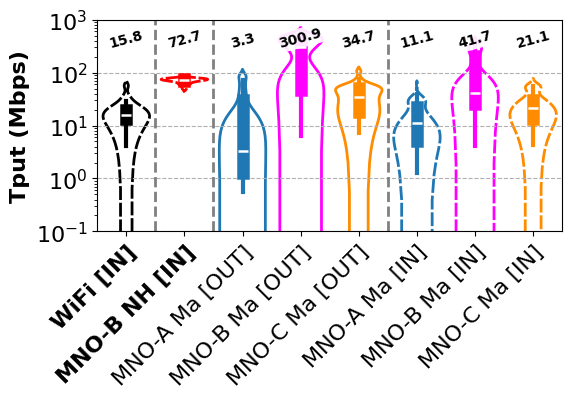

In [10]:
# Application IP Tput
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['WIFI-IN', 'TMO-NH-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN']
palette = ['black', 'red', 'tab:blue', 'magenta', 'darkorange', 'tab:blue', 'magenta', 'darkorange']
sns.violinplot(data=df_app_dl, x='Collection_1', y='Calculated Tput (Mbps)', hue='Collection_1', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
new_labels = ['WiFi [IN]', 'MNO-B NH [IN]', 'MNO-A Ma [OUT]', 'MNO-B Ma [OUT]', 'MNO-C Ma [OUT]', 'MNO-A Ma [IN]', 'MNO-B Ma [IN]', 'MNO-C Ma [IN]']
ax.set_xticklabels(new_labels, ha='right')

medians = df_app_dl.groupby('Collection_1')['Calculated Tput (Mbps)'].median()
for i, collection in enumerate(['WIFI-IN', 'TMO-NH-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN']):
    median_value = medians[collection]
    ax.text(i, 3e2, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

for i in [0,1,5,6,7]:
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=1.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=4.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['WiFi [IN]', 'MNO-B NH [IN]']:
        label.set_fontweight('bold')

plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
# plt.title('HTTP DL Tput', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', axis='y')
plt.yscale('log')
plt.ylim(1e-1, 1e3)
# plt.savefig('figs/app_dl_tput_violin_log.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_60967/2328286709.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, ha='right')


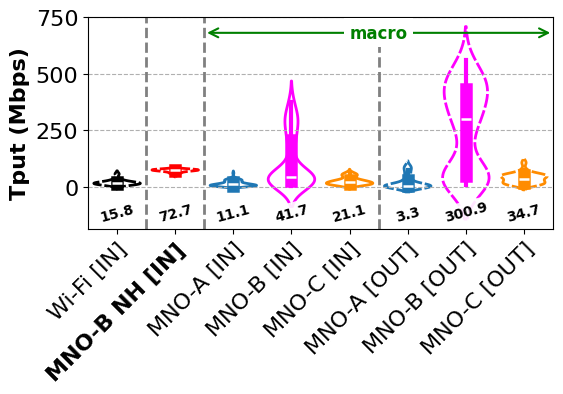

In [11]:
# Application IP Tput
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['WIFI-IN', 'TMO-NH-IN', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT']
palette = ['black', 'red', 'tab:blue', 'magenta', 'darkorange', 'tab:blue', 'magenta', 'darkorange']
sns.violinplot(data=df_app_dl, x='Collection_1', y='Calculated Tput (Mbps)', hue='Collection_1', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
new_labels = ['Wi-Fi [IN]', 'MNO-B NH [IN]', 'MNO-A [IN]', 'MNO-B [IN]', 'MNO-C [IN]', 'MNO-A [OUT]', 'MNO-B [OUT]', 'MNO-C [OUT]']
ax.set_xticklabels(new_labels, ha='right')

medians = df_app_dl.groupby('Collection_1')['Calculated Tput (Mbps)'].median()
for i, collection in enumerate(['WIFI-IN', 'TMO-NH-IN', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT']):
    median_value = medians[collection]
    ax.text(i, -150, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

ax.annotate(
    '', xy=(1.5, 0.925), xytext=(7.5, 0.925),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(5/8, 0.925, 'macro', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

for i in [0,1,5,6,7]:
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=1.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=4.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['WiFi [IN]', 'MNO-B NH [IN]']:
        label.set_fontweight('bold')

plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
# plt.title('HTTP DL Tput', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', axis='y')
# plt.yscale('log')
# plt.ylim(1e-1, 1e3)
# plt.savefig('figs/app_dl_tput_violin.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_60967/1860064528.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, ha='right')


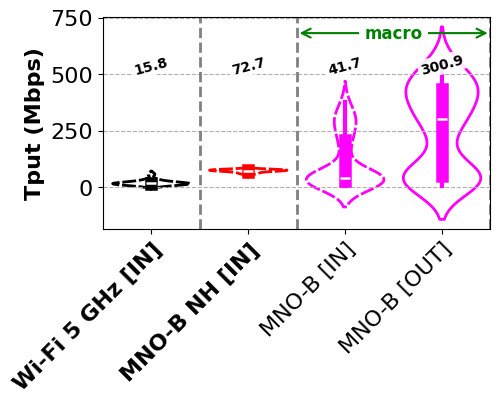

In [15]:
# Application IP Tput
fig, ax = plt.subplots(figsize=(5, 2.75))
# order = ['WIFI-IN', 'TMO-NH-IN', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT']
order = ['WIFI-IN', 'TMO-NH-IN', 'TMO-MNO-IN', 'TMO-MNO-OUT']
# palette = ['black', 'red', 'tab:blue', 'magenta', 'darkorange', 'tab:blue', 'magenta', 'darkorange']
palette = ['black', 'red', 'magenta', 'magenta']
sns.violinplot(data=df_app_dl, x='Collection_1', y='Calculated Tput (Mbps)', hue='Collection_1', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
# new_labels = ['Wi-Fi [IN]', 'MNO-B NH [IN]', 'MNO-A [IN]', 'MNO-B [IN]', 'MNO-C [IN]', 'MNO-A [OUT]', 'MNO-B [OUT]', 'MNO-C [OUT]']
new_labels = ['Wi-Fi 5 GHz [IN]', 'MNO-B NH [IN]', 'MNO-B [IN]', 'MNO-B [OUT]']
ax.set_xticklabels(new_labels, ha='right')

medians = df_app_dl.groupby('Collection_1')['Calculated Tput (Mbps)'].median()
for i, collection in enumerate(['WIFI-IN', 'TMO-NH-IN', 'TMO-MNO-IN', 'TMO-MNO-OUT']):
    median_value = medians[collection]
    ax.text(i, 500, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

ax.annotate(
    '', xy=(1.5, 0.925), xytext=(3.5, 0.925),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(3/4, 0.925, 'macro', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.collections[0].set_linestyle((0,(5,1)))
ax.collections[1].set_linestyle((0,(5,1)))
ax.collections[2].set_linestyle((0,(5,1)))

plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=1.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=3.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')

dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['Wi-Fi 5 GHz [IN]', 'MNO-B NH [IN]']:
        label.set_fontweight('bold')

plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
# plt.title('HTTP DL Tput', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', axis='y')
# plt.yscale('log')
# plt.ylim(1e-1, 1e3)
# plt.savefig('figs/app_select_dl_tput_violin.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_25358/4195324424.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, ha='right')


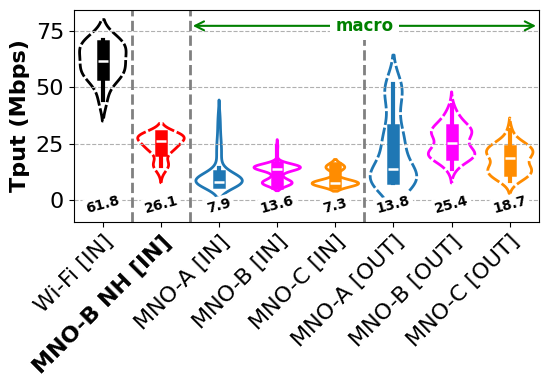

In [ ]:
# Application IP Tput
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['WIFI-IN', 'TMO-NH-IN', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT']
palette = ['black', 'red', 'tab:blue', 'magenta', 'darkorange', 'tab:blue', 'magenta', 'darkorange']
sns.violinplot(data=df_app_ul, x='Collection_1', y='Calculated Tput (Mbps)', hue='Collection_1', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
new_labels = ['Wi-Fi [IN]', 'MNO-B NH [IN]', 'MNO-A [IN]', 'MNO-B [IN]', 'MNO-C [IN]', 'MNO-A [OUT]', 'MNO-B [OUT]', 'MNO-C [OUT]']
ax.set_xticklabels(new_labels, ha='right')

medians = df_app_ul.groupby('Collection_1')['Calculated Tput (Mbps)'].median()
for i, collection in enumerate(['WIFI-IN', 'TMO-NH-IN', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT']):
    median_value = medians[collection]
    ax.text(i, -6, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=1, edgecolor='none', boxstyle='round,pad=0.2'))

ax.annotate(
    '', xy=(1.5, 0.925), xytext=(7.5, 0.925),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(5/8, 0.925, 'macro', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

for i in [0,1,5,6,7]:
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=1.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=4.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['WiFi [IN]', 'MNO-B NH [IN]']:
        label.set_fontweight('bold')

plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
# plt.title('HTTP UL Tput', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', axis='y')
# plt.yscale('log')
# plt.ylim(1e-1, 1e3)
# plt.savefig('figs/app_ul_tput_violin.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_33561/1442050375.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, ha='right')


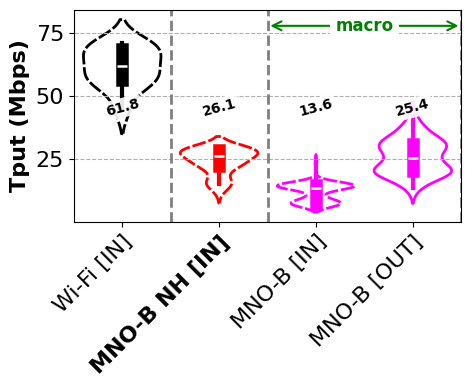

In [25]:
# Application IP Tput
fig, ax = plt.subplots(figsize=(5, 2.75))
# order = ['WIFI-IN', 'TMO-NH-IN', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT']
order = ['WIFI-IN', 'TMO-NH-IN', 'TMO-MNO-IN', 'TMO-MNO-OUT']
# palette = ['black', 'red', 'tab:blue', 'magenta', 'darkorange', 'tab:blue', 'magenta', 'darkorange']
palette = ['black', 'red', 'magenta', 'magenta']
sns.violinplot(data=df_app_ul, x='Collection_1', y='Calculated Tput (Mbps)', hue='Collection_1', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
# new_labels = ['Wi-Fi [IN]', 'MNO-B NH [IN]', 'MNO-A [IN]', 'MNO-B [IN]', 'MNO-C [IN]', 'MNO-A [OUT]', 'MNO-B [OUT]', 'MNO-C [OUT]']
new_labels = ['Wi-Fi [IN]', 'MNO-B NH [IN]', 'MNO-B [IN]', 'MNO-B [OUT]']
ax.set_xticklabels(new_labels, ha='right')

medians = df_app_ul.groupby('Collection_1')['Calculated Tput (Mbps)'].median()
for i, collection in enumerate(['WIFI-IN', 'TMO-NH-IN', 'TMO-MNO-IN', 'TMO-MNO-OUT']):
    median_value = medians[collection]
    ax.text(i, 42, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

ax.annotate(
    '', xy=(1.5, 0.925), xytext=(3.5, 0.925),
    xycoords=('data', 'axes fraction'),
    textcoords=('data', 'axes fraction'),
    arrowprops=dict(arrowstyle='<->', color='green', lw=1.5),
)
ax.text(3/4, 0.925, 'macro', transform=ax.transAxes,
        ha='center', va='center', fontsize=12, fontweight='bold', color='green',
        bbox=dict(facecolor='white', alpha=1, edgecolor='none'))

ax.collections[0].set_linestyle((0,(5,1)))
ax.collections[1].set_linestyle((0,(5,1)))
ax.collections[2].set_linestyle((0,(5,1)))

plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=1.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=3.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')

dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['WiFi [IN]', 'MNO-B NH [IN]']:
        label.set_fontweight('bold')

plt.xlabel('')
plt.ylabel('Tput (Mbps)', fontsize=16, fontweight='bold')
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
# plt.title('HTTP DL Tput', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', axis='y')
# plt.yscale('log')
# plt.ylim(1e-1, 1e3)
plt.savefig('figs/app_select_ul_tput_violin.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_67477/1111348257.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, ha='right')


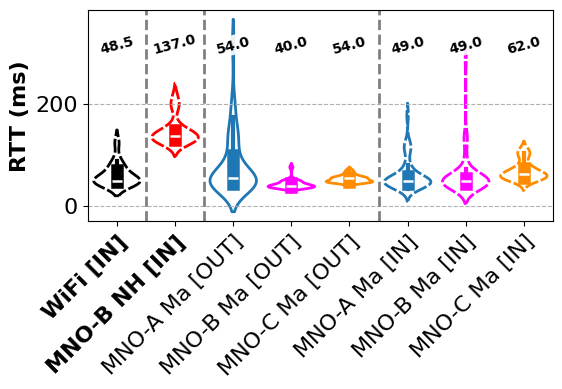

In [119]:
# Application Round Trip Time
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['WIFI-IN', 'TMO-NH-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN']
palette = ['black', 'red', 'tab:blue', 'magenta', 'darkorange', 'tab:blue', 'magenta', 'darkorange']
sns.violinplot(data=df_app_dl, x='Collection_1', y='Round Trip Time', hue='Collection_1', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
new_labels = ['WiFi [IN]', 'MNO-B NH [IN]', 'MNO-A Ma [OUT]', 'MNO-B Ma [OUT]', 'MNO-C Ma [OUT]', 'MNO-A Ma [IN]', 'MNO-B Ma [IN]', 'MNO-C Ma [IN]']
ax.set_xticklabels(new_labels, ha='right')

medians = df_app_dl.groupby('Collection_1')['Round Trip Time'].median()
for i, collection in enumerate(['WIFI-IN', 'TMO-NH-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN']):
    median_value = medians[collection]
    ax.text(i, 3e2, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

for i in [0,1,5,6,7]:
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=1.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=4.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['WiFi [IN]', 'MNO-B NH [IN]']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RTT (ms)', fontsize=16, fontweight='bold')
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
# plt.title('DL RTT', fontsize=16, fontweight='bold')
plt.grid(True, axis='y', linestyle='--')
# plt.savefig('figs/app_dl_rtt_violin.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_67477/4021702976.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, ha='right')


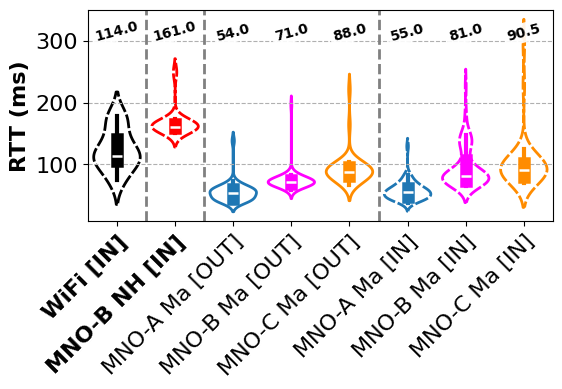

In [120]:
# Application Round Trip Time
fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['WIFI-IN', 'TMO-NH-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN']
palette = ['black', 'red', 'tab:blue', 'magenta', 'darkorange', 'tab:blue', 'magenta', 'darkorange']
sns.violinplot(data=df_app_ul, x='Collection_1', y='Round Trip Time', hue='Collection_1', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
new_labels = ['WiFi [IN]', 'MNO-B NH [IN]', 'MNO-A Ma [OUT]', 'MNO-B Ma [OUT]', 'MNO-C Ma [OUT]', 'MNO-A Ma [IN]', 'MNO-B Ma [IN]', 'MNO-C Ma [IN]']
ax.set_xticklabels(new_labels, ha='right')

medians = df_app_ul.groupby('Collection_1')['Round Trip Time'].median()
for i, collection in enumerate(['WIFI-IN', 'TMO-NH-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN']):
    median_value = medians[collection]
    ax.text(i, 3e2, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

for i in [0,1,5,6,7]:
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=1.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=4.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['WiFi [IN]', 'MNO-B NH [IN]']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('RTT (ms)', fontsize=16, fontweight='bold')
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{int(y/1e3)}'))
# plt.title('UL RTT', fontsize=16, fontweight='bold')
plt.grid(True, axis='y', linestyle='--')
# plt.savefig('figs/app_ul_rtt_violin.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette

#### Ping

In [121]:
df_app_ping = pd.read_csv('../_data/Spring2025_ArkansasNH/app_ping.csv')
df_app_ping = df_app_ping[df_app_ping['Test Status'] == 'Completed']

In [122]:
df_app_ping['Collection_1'] = np.nan

df_app_ping['Collection_1'] = np.where(df_app_ping['Collection'].isin(['Day1-WIFI-IN']), 'WIFI-IN', df_app_ping['Collection_1'])
df_app_ping['Collection_1'] = np.where(df_app_ping['Collection'].isin(['Day1-ATT-NH-IN']), 'ATT-NH-IN', df_app_ping['Collection_1'])
df_app_ping['Collection_1'] = np.where(df_app_ping['Collection'].isin(['Day1-TMO-NH-IN']), 'TMO-NH-IN', df_app_ping['Collection_1'])
df_app_ping['Collection_1'] = np.where(df_app_ping['Collection'].isin(['Day2-ATT-MNO-DEF-OUT', 'Day2-ATT-MNO-4G-OUT', 'Day1-ATT-MNO-DEF-OUT']), 'ATT-MNO-OUT', df_app_ping['Collection_1'])
df_app_ping['Collection_1'] = np.where(df_app_ping['Collection'].isin(['Day1-TMO-MNO-DEF-OUT', 'Day2-TMO-MNO-4G-OUT', 'Day2-TMO-MNO-DEF-OUT']), 'TMO-MNO-OUT', df_app_ping['Collection_1'])
df_app_ping['Collection_1'] = np.where(df_app_ping['Collection'].isin(['Day2-VZN-MNO-4G-OUT', 'Day2-VZN-MNO-DEF-OUT']), 'VZN-MNO-OUT', df_app_ping['Collection_1'])
df_app_ping['Collection_1'] = np.where(df_app_ping['Collection'].isin(['Day2-ATT-MNO-4G-IN', 'Day2-ATT-MNO-DEF-IN', 'Day1-ATT-MNO-DEF-IN']), 'ATT-MNO-IN', df_app_ping['Collection_1'])
df_app_ping['Collection_1'] = np.where(df_app_ping['Collection'].isin(['Day1-TMO-MNO-DEF-IN', 'Day2-TMO-MNO-4G-IN', 'Day2-TMO-MNO-DEF-IN']), 'TMO-MNO-IN', df_app_ping['Collection_1'])
df_app_ping['Collection_1'] = np.where(df_app_ping['Collection'].isin(['Day2-VZN-MNO-DEF-IN', 'Day2-VZN-MNO-4G-IN']), 'VZN-MNO-IN', df_app_ping['Collection_1'])

### Retaining 95 percentile of the data
df_app_ping = df_app_ping[df_app_ping['Round Trip Time Average'] <= df_app_ping['Round Trip Time Average'].quantile(0.95)]

/var/folders/j_/lbf42_q147v8jdwz_w2my7_c0000gn/T/ipykernel_67477/2131277295.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels, ha='right')


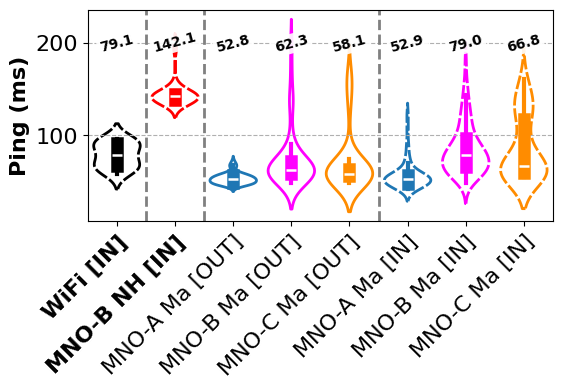

In [ ]:
# Application Ping

fig, ax = plt.subplots(figsize=(6, 2.75))
order = ['WIFI-IN', 'TMO-NH-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN']
palette = ['black', 'red', 'tab:blue', 'magenta', 'darkorange', 'tab:blue', 'magenta', 'darkorange']
sns.violinplot(data=df_app_ping, x='Collection_1', y='Round Trip Time Average', hue='Collection_1', fill=False, linewidth=2, order=order, hue_order=order, palette=palette, ax=ax)
new_labels = ['WiFi [IN]', 'MNO-B NH [IN]', 'MNO-A Ma [OUT]', 'MNO-B Ma [OUT]', 'MNO-C Ma [OUT]', 'MNO-A Ma [IN]', 'MNO-B Ma [IN]', 'MNO-C Ma [IN]']
ax.set_xticklabels(new_labels, ha='right')

medians = df_app_ping.groupby('Collection_1')['Round Trip Time Average'].median()
for i, collection in enumerate(['WIFI-IN', 'TMO-NH-IN', 'ATT-MNO-OUT', 'TMO-MNO-OUT', 'VZN-MNO-OUT', 'ATT-MNO-IN', 'TMO-MNO-IN', 'VZN-MNO-IN']):
    median_value = medians[collection]
    ax.text(i, 190, f'{medians[collection]:.1f}',ha='center', color='black', fontsize=10, fontweight='bold', rotation=15,bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2'))

for i in [0,1,5,6,7]:
    ax.collections[i].set_linestyle((0,(5,1))) # for densly dashed lines
plt.axvline(x=0.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=1.5, color='gray', linestyle='--', linewidth=2)
plt.axvline(x=4.5, color='gray', linestyle='--', linewidth=2)
plt.xticks(rotation=45, ha='right')
dx = 10 / 72
dy = 0 / 72
offset = ScaledTranslation(dx, dy, fig.dpi_scale_trans)
for label in ax.xaxis.get_majorticklabels():
    label.set_transform(label.get_transform() + offset)

labels = plt.gca().get_xticklabels()
for label in labels:
    if label.get_text() in ['WiFi [IN]', 'MNO-B NH [IN]']:
        label.set_fontweight('bold')
plt.xlabel('')
plt.ylabel('Ping (ms)', fontsize=16, fontweight='bold')
plt.grid(True, axis='y', linestyle='--')
# plt.savefig('figs/app_ping_violin.pdf', bbox_inches='tight')
plt.show()
del fig, ax, dx, dy, offset, label, order, palette